In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm

from fastai.vision import *
from fastai.metrics import error_rate

# Import data

## Images

Get filenames

In [2]:
file_names = os.listdir('Data/images')
file_names[:5]

['models', 'Test_0.jpg', 'Test_1.jpg', 'Test_10.jpg', 'Test_100.jpg']

**Divide into Train and Test sets**

In [3]:
train_filenames = []
test_filenames = []
for file_name in file_names:
    if 'Train' in file_name:
        train_filenames.append(file_name)
    else: 
        test_filenames.append(file_name)
print(f'There are {len(train_filenames)} train images and {len(test_filenames)} test images')

There are 1821 train images and 1822 test images


See a sample

In [4]:
img = cv2.imread(f'Data/images/{train_filenames[0]}')
img.shape

(1365, 2048, 3)

In [5]:
# plt.imshow(img);

Load data into a numpy array with reduce image sizes

In [5]:
train_images = np.zeros((len(train_filenames), img.shape[0]//7,int((img.shape[0]//7)*1.5),3))
count = 0
for file in tqdm(train_filenames):
    image = cv2.imread(f'Data/images/{file}')
    small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
    train_images[count,:,:,:] = small_img
    count += 1

In [7]:
# test_images = np.zeros((img.shape[0]//7,int((img.shape[0]/7)*1.5),(len(test_filenames))))
# count = 0
# for file in tqdm(test_filenames):
#     image = cv2.imread(f'Data/images/{file}')
#     small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
#     test_images[:,:,count] = im_data
#     count += 1

See the new sample

In [ ]:
# plt.imshow(np.array(train_images[0]).astype(np.int));

## Labels

In [6]:
train_labels = pd.read_csv('Data/train.csv')
test_labels = pd.read_csv('Data/test.csv')
train_labels.shape, test_labels.shape

((1821, 5), (1821, 1))

In [7]:
train_labels.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0


The images have a different order

In [8]:
train_labels['idx'] = train_labels.image_id.apply(lambda x: train_filenames.index(x+'.jpg'))
train_labels.sort_values(by='idx', inplace=True)
# test_labels['idx'] = test_labels.image_id.apply(lambda x: test_filenames.index(x+'.jpg'))
# test_labels.sort_values(by='idx', inplace=True)
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx
0,Train_0,0,0,0,1,0
1,Train_1,0,1,0,0,1
10,Train_10,0,0,1,0,2
100,Train_100,1,0,0,0,3
1000,Train_1000,0,0,1,0,4


In [9]:
train_labels.loc[train_labels.healthy == 1, 'label'] = 'healthy'
train_labels.loc[train_labels.multiple_diseases == 1, 'label'] = 'multiple_diseases'
train_labels.loc[train_labels.rust == 1, 'label'] = 'rust'
train_labels.loc[train_labels.scab == 1, 'label'] = 'scab'
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx,label
0,Train_0,0,0,0,1,0,scab
1,Train_1,0,1,0,0,1,multiple_diseases
10,Train_10,0,0,1,0,2,rust
100,Train_100,1,0,0,0,3,healthy
1000,Train_1000,0,0,1,0,4,rust


Some insight

In [ ]:
# fig, ax = plt.subplots(2,2, figsize=(20,10))
# sns.countplot(train_labels.healthy, ax=ax[0,0])
# sns.countplot(train_labels.multiple_diseases, ax=ax[0,1])
# sns.countplot(train_labels.rust, ax=ax[1,0])
# sns.countplot(train_labels.scab, ax=ax[1,1])
# plt.show()

# Train - Test sets split

In [10]:
X_train = train_images[:int(len(train_images)*0.8),:,:]
X_test = train_images[int(len(train_images)*0.8):,:,:]
X_train.shape, X_test.shape

((1456, 195, 292, 3), (365, 195, 292, 3))

In [11]:
y_train = np.array(train_labels.label.iloc[:int(train_images.shape[0]*0.8)].values.tolist())
y_test = np.array(train_labels.label.iloc[int(train_images.shape[0]*0.8):].values.tolist())
len(y_train), len(y_test)

(1456, 365)

# Modeling

In [12]:
bs = 16

In [33]:
data = ImageDataBunch.from_lists('Data/images', ['Data/images/' + s for s in train_filenames], list(train_labels.label),
                                 size=224, bs=bs).normalize(imagenet_stats)

NameError: name 'ImageItemList' is not defined

In [ ]:
# data.show_batch(rows=3, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes),data.c

['healthy', 'multiple_diseases', 'rust', 'scab']


(4, 4)

# Training: resnet34

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
# learn.load('model-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,healthy,rust,healthy,scab
Path: Data\images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
scab,healthy,healthy,scab,healthy
Path: Data\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001E5BA5F6048>
Traceback (most recent call last):
  File "C:\Users\jvine\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "C:\Users\jvine\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "C:\Users\jvine\Anaconda3\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "C:\Users\jvine\Anaconda3\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [23]:
learn.save('model-resnet34')

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

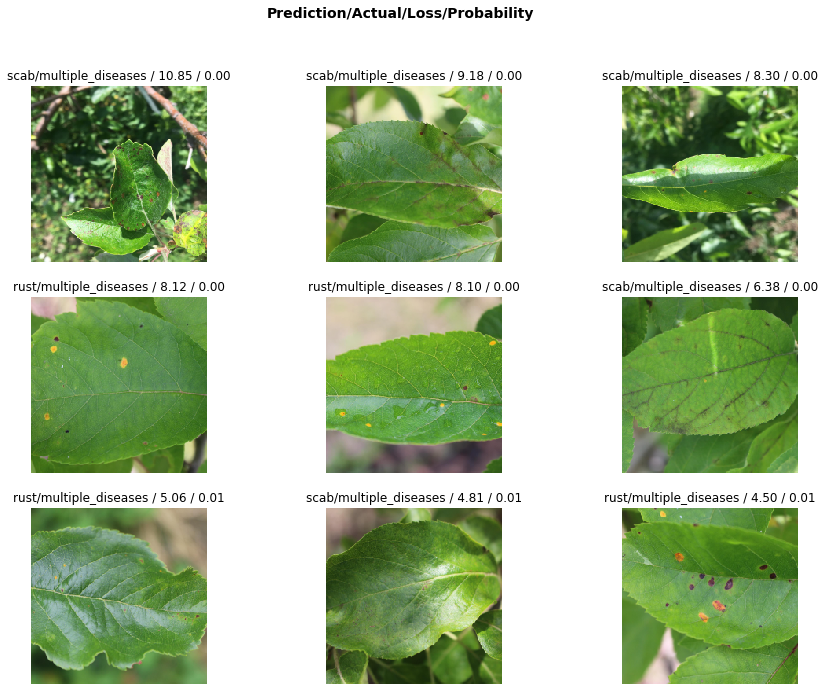

In [25]:
# interp.plot_top_losses(9, figsize=(15,11))

In [26]:
doc(interp.plot_top_losses)

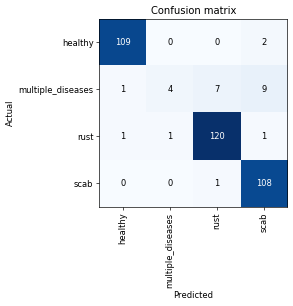

In [27]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [28]:
interp.most_confused(min_val=2)

[('multiple_diseases', 'scab', 9),
 ('multiple_diseases', 'rust', 7),
 ('healthy', 'scab', 2)]

In [29]:
cm = interp.confusion_matrix()

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


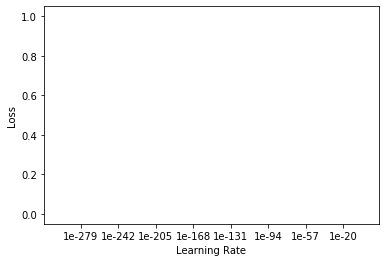

In [32]:
learn.recorder.plot()

## Training: resnet50

In [98]:
data = ImageDataBunch.from_lists('Data/images', ['Data/images/' + s for s in train_filenames], list(train_labels.healthy),
                                 size=224, bs=bs//16).normalize(imagenet_stats)

In [99]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 1.28 GiB already allocated; 950.40 KiB free; 1.31 GiB reserved in total by PyTorch)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.26 GiB already allocated; 950.40 KiB free; 1.31 GiB reserved in total by PyTorch)

In [91]:
learn.save('model-resnet50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

# Predicting the test set

## Test prediction

In [44]:
test_img = open_image(f'Data/images/{test_filenames[1]}')
test_img.shape

torch.Size([3, 1365, 2048])

In [45]:
learn.predict(test_img)

(Category tensor(2),
 tensor(2),
 tensor([3.0390e-08, 1.0723e-04, 9.9989e-01, 6.9199e-08]))

## Predictions

In [51]:
prediction_probabilities = []
for i in tqdm(range(1, len(test_filenames))):
    test_img = open_image(f'Data/images/{test_filenames[i]}')
    prediction_probabilities.append(learn.predict(test_img)[-1].tolist())

In [78]:
submission_df = pd.DataFrame(prediction_probabilities, columns=learn.data.classes)
submission_df.shape

(1821, 4)

In [79]:
submission_df.head(2)

,healthy,multiple_diseases,rust,scab
0,3.038962e-08,0.000107,0.999893,6.919942e-08
1,2.060615e-09,0.000140,0.999682,1.783924e-04


In [80]:
submission_df['img_name'] = test_filenames[1:]

In [81]:
submission_df['index'] = submission_df.img_name.apply(lambda s: int(s[5:-4]))
submission_df.sort_values(by='index', inplace=True)

In [82]:
submission_df.head()

,healthy,multiple_diseases,rust,scab,img_name,index
0,3.038962e-08,0.000107,9.998926e-01,6.919942e-08,Test_0.jpg,0
1,2.060615e-09,0.000140,9.996816e-01,1.783924e-04,Test_1.jpg,1
933,2.028427e-05,0.000020,1.620629e-09,9.999601e-01,Test_2.jpg,2
1044,9.993881e-01,0.000006,5.167568e-04,8.900905e-05,Test_3.jpg,3
1155,7.169218e-08,0.007892,9.920492e-01,5.848732e-05,Test_4.jpg,4


In [85]:
submission_df['image_id'] = submission_df.img_name.apply(lambda s: s[:-4])

In [86]:
submission_df[['image_id','healthy','multiple_diseases','rust','scab']]

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,3.038962e-08,0.000107,9.998926e-01,6.919942e-08
1,Test_1,2.060615e-09,0.000140,9.996816e-01,1.783924e-04
933,Test_2,2.028427e-05,0.000020,1.620629e-09,9.999601e-01
1044,Test_3,9.993881e-01,0.000006,5.167568e-04,8.900905e-05
1155,Test_4,7.169218e-08,0.007892,9.920492e-01,5.848732e-05
...,...,...,...,...,...
909,Test_1816,3.390961e-10,0.006964,9.930354e-01,1.972139e-07
910,Test_1817,1.345985e-03,0.215075,5.315140e-01,2.520650e-01
911,Test_1818,1.704270e-04,0.000063,9.997117e-01,5.475899e-05
912,Test_1819,9.999774e-01,0.000008,5.064775e-06,9.239431e-06


In [88]:
submission_df[['image_id','healthy','multiple_diseases','rust','scab']].to_csv('Data/submission.csv', index=False)